In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np

"Machine learning tools"
import pickle

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier

from classification.datasets import Dataset
from classification.utils.audio_student import AudioUtil, Feature_vector_DS

from classification.utils.plots import (
    plot_decision_boundaries,
    plot_specgram,
    show_confusion_matrix,
)
from classification.utils.utils import accuracy

In [3]:
np.random.seed(0)

In [4]:
### TO RUN
dataset = Dataset()
classnames = dataset.list_classes()

print("\n".join(classnames))

chainsaw
fire
fireworks
gun


In [5]:
### TO RUN
fm_dir = "data/feature_matrices/"  # where to save the features matrices
model_dir = "data/models/"  # where to save the models
os.makedirs(fm_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [6]:
### TO RUN

"Creation of the dataset"
myds = Feature_vector_DS(dataset, Nft=512, nmel=20, duration=950, shift_pct=0.0)

"Some attributes..."
myds.nmel
myds.duration
myds.shift_pct
myds.sr
myds.data_aug
myds.ncol


idx = 0


In [7]:
### TO RUN
"Random split of 70:30 between training and validation"
train_pct = 0.7

featveclen = len(myds["fire", 0, ""])  # number of items in a feature vector
nitems = len(myds)  # number of sounds in the dataset
naudio = dataset.naudio  # number of audio files in each class
nclass = dataset.nclass  # number of classes
nlearn = round(naudio * train_pct)  # number of sounds among naudio for training

data_aug_factor = 1
class_ids_aug = np.repeat(classnames, naudio * data_aug_factor)

"""
X = np.zeros((data_aug_factor * nclass * naudio, featveclen))
for s in range(data_aug_factor):
    for class_idx, classname in enumerate(classnames):
        for idx in range(naudio):
            featvec = myds[classname, idx, ""]
            X[s * nclass * naudio + class_idx * naudio + idx, :] = featvec
np.save(fm_dir + "X_basic.npy", X)
y = class_ids_aug.copy()
np.save(fm_dir + "y_basic.npy", y)
"""

X = np.load(fm_dir+"X_basic.npy")
y = np.load(fm_dir+"y_basic.npy")

print(f"Shape of the feature matrix : {X.shape}")
print(f"Number of labels : {len(y)}")

Shape of the feature matrix : (160, 400)
Number of labels : 160


We can now create a new augmented dataset and observe if the classification results improve. 

In [8]:
### AUGMENTED DATASET
list_augmentation = ["original", "noise", "echo", "shifting"]
myds.mod_data_aug(list_augmentation)
print("Number of transformations : ", myds.data_aug_factor)
y_aug = np.repeat(classnames, dataset.naudio * myds.data_aug_factor)
X_aug = np.zeros((myds.data_aug_factor * nclass * naudio, featveclen))

for s in range(len(list_augmentation)):
    aug = list_augmentation[s]
    for idx in range(dataset.naudio):
        for class_idx, classname in enumerate(classnames):
            featvec = myds[classname, idx, aug]
            X_aug[s * nclass * naudio + class_idx * naudio + idx, :] = featvec
            y_aug[s * nclass * naudio + class_idx * naudio + idx] = classname


print(f"Shape of the feature matrix : {X_aug.shape}")
print(f"------------------------------------------------------------")
print(f"200 of each transformation. Order : chainsaw1, fire1, fireworks1, gun1, chainsaw2, fire2, ...")


Number of transformations :  4
Shape of the feature matrix : (640, 400)
------------------------------------------------------------
200 of each transformation. Order : chainsaw1, fire1, fireworks1, gun1, chainsaw2, fire2, ...


FINAL MODEL SAVE

Number of principal features kept: 119


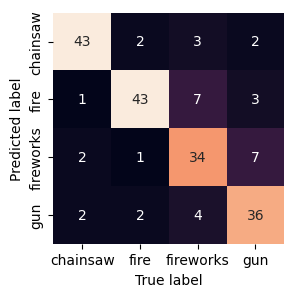


Overall Metrics:
Test Accuracy (Overall): 0.8125
Mean CV Accuracy: 0.7903

Per-Class Metrics:
Class chainsaw:
  Precision: 0.8600
  Recall: 0.8958
  Accuracy: 0.8958
Class fire:
  Precision: 0.7963
  Recall: 0.8958
  Accuracy: 0.8958
Class fireworks:
  Precision: 0.7727
  Recall: 0.7083
  Accuracy: 0.7083
Class gun:
  Precision: 0.8182
  Recall: 0.7500
  Accuracy: 0.7500

Model saved as data/models/final_model_with_pca.pickle
PCA Transformer saved as data/models/pca_transform.pickle


<Figure size 640x480 with 0 Axes>

In [ ]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from collections import defaultdict

# Directories
fm_dir = "data/feature_matrices/"
model_dir = "data/models/"
os.makedirs(fm_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

# Load dataset
X = X_aug
y = y_aug

# Shuffle then split the dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y
)

# Apply PCA to reduce dimensionality (keeps 95% variance)
pca = PCA(n_components=0.98)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)  # Apply same transformation to test data
print(f"Number of principal features kept: {pca.n_components_}")

# Train the Random Forest model with PCA embedded
class PCA_RF_Model:
    def __init__(self, pca, model):
        self.pca = pca
        self.model = model
    
    def fit(self, X, y):
        X_pca = self.pca.fit_transform(X)
        self.model.fit(X_pca, y)
    
    def predict(self, X):
        X_pca = self.pca.transform(X)
        return self.model.predict(X_pca)
    
    def predict_proba(self, X):
        X_pca = self.pca.transform(X)
        return self.model.predict_proba(X_pca)

# Define the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=400,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

# Wrap PCA and RF in a single model
pca_rf_model = PCA_RF_Model(pca, rf_model)
pca_rf_model.fit(X_train, y_train)

# Evaluate model
predict = pca_rf_model.predict(X_test)

# Compute metrics for each class
classes = np.unique(y_test)
precision_per_class = precision_score(y_test, predict, average=None, labels=classes)
recall_per_class = recall_score(y_test, predict, average=None, labels=classes)

test_accuracy_per_class = []
conf_matrix = confusion_matrix(y_test, predict, labels=classes)

for i, cls in enumerate(classes):
    # Calculate accuracy for each class
    class_accuracy = conf_matrix[i, i] / conf_matrix[i, :].sum()
    test_accuracy_per_class.append(class_accuracy)

# Cross-validation accuracy
cv_scores = cross_val_score(pca_rf_model.model, pca.transform(X_train), y_train, cv=10, scoring='accuracy')
mean_cv_accuracy = np.mean(cv_scores)

# Print results
print("\nOverall Metrics:")
print(f"Test Accuracy (Overall): {np.mean(predict == y_test):.4f}")
print(f"Mean CV Accuracy: {mean_cv_accuracy:.4f}")

print("\nPer-Class Metrics:")
for i, cls in enumerate(classes):
    print(f"Class {cls}:")
    print(f"  Precision: {precision_per_class[i]:.4f}")
    print(f"  Recall: {recall_per_class[i]:.4f}")
    print(f"  Accuracy: {test_accuracy_per_class[i]:.4f}")

# SAVE THE MODEL (PCA included)
filename = os.path.join(model_dir, "final_model_with_pca.pickle")
with open(filename, "wb") as model_file:
    pickle.dump(pca_rf_model, model_file)

print(f"\nModel saved as {filename}")


MEAN ACCURACY ON 100 ITERATIONS

In [10]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from classification.utils.utils import accuracy

# Directories for saving models
model_dir = "data/models/"
os.makedirs(model_dir, exist_ok=True)

# Ensure dataset (X_aug, y_aug) exists
try:
    X = X_aug
    y = y_aug
except NameError:
    raise ValueError("X_aug and y_aug must be defined before running this script.")

# Number of iterations
num_iterations = 20

# Lists to store scores
accuracy_scores = []
cv_accuracy_scores = []

for i in range(num_iterations):
    print(f"\nIteration {i + 1}/{num_iterations}")

    # Split the dataset into training and testing subsets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=i  # Different splits per iteration
    )

    # Train the Random Forest model
    model = RandomForestClassifier(
        n_estimators=400,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=i  # Different initialization per iteration
    )
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Compute overall accuracy
    test_accuracy = accuracy(y_pred, y_test)
    accuracy_scores.append(test_accuracy)

    # Perform cross-validation on the training set
    cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
    mean_cv_accuracy = np.mean(cv_scores)
    cv_accuracy_scores.append(mean_cv_accuracy)

    print(f"Test Accuracy: {test_accuracy:.4f} | Mean CV Accuracy: {mean_cv_accuracy:.4f}")

# Compute overall statistics
mean_test_accuracy = np.mean(accuracy_scores)
std_test_accuracy = np.std(accuracy_scores)

mean_cv_accuracy = np.mean(cv_accuracy_scores)
std_cv_accuracy = np.std(cv_accuracy_scores)

# Print final results
print("\n=== FINAL RESULTS AFTER 100 ITERATIONS ===")
print(f"Mean Test Accuracy: {mean_test_accuracy:.4f} ± {std_test_accuracy:.4f}")
print(f"Mean Cross-Validation Accuracy: {mean_cv_accuracy:.4f} ± {std_cv_accuracy:.4f}")



Iteration 1/20


Test Accuracy: 0.7656 | Mean CV Accuracy: 0.7566

Iteration 2/20
Test Accuracy: 0.7604 | Mean CV Accuracy: 0.7677

Iteration 3/20
Test Accuracy: 0.7760 | Mean CV Accuracy: 0.7746

Iteration 4/20
Test Accuracy: 0.8229 | Mean CV Accuracy: 0.7791

Iteration 5/20
Test Accuracy: 0.7656 | Mean CV Accuracy: 0.7811

Iteration 6/20
Test Accuracy: 0.7552 | Mean CV Accuracy: 0.7748

Iteration 7/20
Test Accuracy: 0.7604 | Mean CV Accuracy: 0.7767

Iteration 8/20
Test Accuracy: 0.8333 | Mean CV Accuracy: 0.7657

Iteration 9/20
Test Accuracy: 0.7812 | Mean CV Accuracy: 0.7611

Iteration 10/20
Test Accuracy: 0.7812 | Mean CV Accuracy: 0.7860

Iteration 11/20
Test Accuracy: 0.7760 | Mean CV Accuracy: 0.7815

Iteration 12/20
Test Accuracy: 0.7500 | Mean CV Accuracy: 0.7879

Iteration 13/20
Test Accuracy: 0.7917 | Mean CV Accuracy: 0.7968

Iteration 14/20
Test Accuracy: 0.7760 | Mean CV Accuracy: 0.7680

Iteration 15/20
Test Accuracy: 0.7500 | Mean CV Accuracy: 0.7834

Iteration 16/20
Test Accuracy: 0.7